In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "iciar_mobilenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = MobileNet(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 1s - loss: 0.5830 - acc: 0.7138 - val_loss: 0.3881 - val_acc: 0.8328
Epoch 2/1000
 - 0s - loss: 0.3881 - acc: 0.8269 - val_loss: 0.3149 - val_acc: 0.8769
Epoch 3/1000
 - 0s - loss: 0.3148 - acc: 0.8641 - val_loss: 0.2734 - val_acc: 0.8925
Epoch 4/1000
 - 0s - loss: 0.2568 - acc: 0.9010 - val_loss: 0.2348 - val_acc: 0.9125
Epoch 5/1000
 - 0s - loss: 0.2209 - acc: 0.9160 - val_loss: 0.2030 - val_acc: 0.9307
Epoch 6/1000
 - 0s - loss: 0.1874 - acc: 0.9322 - val_loss: 0.1805 - val_acc: 0.9402
Epoch 7/1000
 - 0s - loss: 0.1661 - acc: 0.9437 - val_loss: 0.1645 - val_acc: 0.9463
Epoch 8/1000
 - 0s - loss: 0.1415 - acc: 0.9530 - val_loss: 0.1509 - val_acc: 0.9489
Epoch 9/1000
 - 0s - loss: 0.1260 - acc: 0.9619 - val_loss: 0.1367 - val_acc: 0.9532
Epoch 10/1000
 - 0s - loss: 0.1091 - acc: 0.9683 - val_loss: 0.1205 - val_acc: 0.9662
Epoch 11/1000
 - 0s - loss: 0.0982 - acc: 0.9706 - val_loss: 0.1184 - val_acc: 0.9671
Epoch 12/1000
 

Epoch 94/1000
 - 0s - loss: 2.4014e-04 - acc: 0.9997 - val_loss: 0.0396 - val_acc: 0.9913
Epoch 95/1000
 - 0s - loss: 2.6176e-05 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9905
Epoch 96/1000
 - 0s - loss: 2.9525e-05 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9896
Epoch 97/1000
 - 0s - loss: 8.6303e-05 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9905
Epoch 98/1000
 - 0s - loss: 4.1102e-05 - acc: 1.0000 - val_loss: 0.0418 - val_acc: 0.9896
Epoch 99/1000
 - 0s - loss: 1.1337e-04 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9913
Epoch 100/1000
 - 0s - loss: 2.5799e-05 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9905
Epoch 101/1000
 - 0s - loss: 1.9711e-05 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9896
Epoch 102/1000
 - 0s - loss: 1.7149e-04 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 0.9905
Epoch 103/1000
 - 0s - loss: 2.5502e-05 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9896
Epoch 104/1000
 - 0s - loss: 2.1882e-05 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.9913
Epoch

 - 0s - loss: 5.6930e-07 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 0.9913
Epoch 185/1000
 - 0s - loss: 1.1012e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9905
Epoch 186/1000
 - 0s - loss: 5.0833e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9913
Epoch 187/1000
 - 0s - loss: 8.9528e-07 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9913
Epoch 188/1000
 - 0s - loss: 9.0558e-07 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9913
Epoch 189/1000
 - 0s - loss: 1.3763e-06 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9922
Epoch 190/1000
 - 0s - loss: 5.9147e-05 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9913
Epoch 191/1000
 - 0s - loss: 2.9796e-07 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9913
Epoch 192/1000
 - 0s - loss: 1.2635e-05 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 0.9905
Epoch 193/1000
 - 0s - loss: 4.0579e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9913
Epoch 194/1000
 - 0s - loss: 6.9733e-07 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9913
Epoch 195/1000

Epoch 275/1000
 - 0s - loss: 1.9607e-07 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9913
Epoch 276/1000
 - 0s - loss: 2.1320e-07 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9922
Epoch 277/1000
 - 0s - loss: 3.4047e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9913
Epoch 278/1000
 - 0s - loss: 1.5572e-07 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9913
Epoch 279/1000
 - 0s - loss: 2.4187e-07 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9905
Epoch 280/1000
 - 0s - loss: 1.8509e-07 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 0.9913
Epoch 281/1000
 - 0s - loss: 4.5488e-07 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9922
Epoch 282/1000
 - 0s - loss: 7.8441e-07 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9913
Epoch 283/1000
 - 0s - loss: 1.9359e-07 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9913
Epoch 284/1000
 - 0s - loss: 4.1165e-07 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9913
Epoch 285/1000
 - 0s - loss: 1.2318e-06 - acc: 1.0000 - val_loss: 0.0627 - val_acc: 0.9905

 - 2s - loss: 1.4480e-07 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9913
Epoch 366/1000
 - 2s - loss: 1.6704e-07 - acc: 1.0000 - val_loss: 0.0667 - val_acc: 0.9905
Epoch 367/1000
 - 2s - loss: 1.9060e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9913
Epoch 368/1000
 - 2s - loss: 1.6894e-07 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9913
Epoch 369/1000
 - 2s - loss: 1.3907e-07 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9913
Epoch 370/1000
 - 2s - loss: 1.4753e-07 - acc: 1.0000 - val_loss: 0.0624 - val_acc: 0.9913
Epoch 371/1000
 - 2s - loss: 1.3305e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9922
Epoch 372/1000
 - 2s - loss: 1.5135e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9913
Epoch 373/1000
 - 2s - loss: 1.7911e-07 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9913
Epoch 374/1000
 - 2s - loss: 1.3159e-07 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9913
Epoch 375/1000
 - 2s - loss: 1.2884e-07 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9922
Epoch 376/1000

Epoch 456/1000
 - 2s - loss: 1.3759e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9913
Epoch 457/1000
 - 2s - loss: 1.3654e-07 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9913
Epoch 458/1000
 - 2s - loss: 1.5587e-07 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9913
Epoch 459/1000
 - 2s - loss: 1.2636e-07 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9913
Epoch 460/1000
 - 2s - loss: 1.2722e-07 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9913
Epoch 461/1000
 - 2s - loss: 1.2418e-07 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9913
Epoch 462/1000
 - 2s - loss: 1.2968e-07 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9913
Epoch 463/1000
 - 2s - loss: 1.3723e-07 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9922
Epoch 464/1000
 - 2s - loss: 1.2516e-07 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9913
Epoch 465/1000
 - 2s - loss: 2.0348e-07 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9922
Epoch 466/1000
 - 2s - loss: 1.9268e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9913

 - 0s - loss: 2.9203e-07 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9913
Epoch 547/1000
 - 0s - loss: 1.4420e-07 - acc: 1.0000 - val_loss: 0.0623 - val_acc: 0.9913
Epoch 548/1000
 - 0s - loss: 1.2810e-07 - acc: 1.0000 - val_loss: 0.0619 - val_acc: 0.9913
Epoch 549/1000
 - 0s - loss: 1.2394e-07 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9913
Epoch 550/1000
 - 0s - loss: 1.2363e-07 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9913
Epoch 551/1000
 - 0s - loss: 1.2492e-07 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9913
Epoch 552/1000
 - 0s - loss: 1.2994e-07 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 0.9922
Epoch 553/1000
 - 0s - loss: 1.2241e-07 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 0.9922
Epoch 554/1000
 - 0s - loss: 1.2906e-07 - acc: 1.0000 - val_loss: 0.0597 - val_acc: 0.9922
Epoch 555/1000
 - 0s - loss: 1.2201e-07 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 0.9922
Epoch 556/1000
 - 0s - loss: 2.5538e-07 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9913
Epoch 557/1000

Epoch 637/1000
 - 0s - loss: 1.3378e-07 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9913
Epoch 638/1000
 - 0s - loss: 1.2404e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9913
Epoch 639/1000
 - 0s - loss: 1.2562e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9922
Epoch 640/1000
 - 0s - loss: 1.2261e-07 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9913
Epoch 641/1000
 - 0s - loss: 1.2440e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9913
Epoch 642/1000
 - 0s - loss: 1.2308e-07 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9913
Epoch 643/1000
 - 0s - loss: 1.7301e-07 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 0.9913
Epoch 644/1000
 - 0s - loss: 1.3947e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9913
Epoch 645/1000
 - 0s - loss: 1.2466e-07 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9922
Epoch 646/1000
 - 0s - loss: 1.2163e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9913
Epoch 647/1000
 - 0s - loss: 1.2282e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9922

 - 0s - loss: 1.2795e-07 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9922
Epoch 728/1000
 - 0s - loss: 1.3061e-07 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9913
Epoch 729/1000
 - 0s - loss: 1.2093e-07 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9913
Epoch 730/1000
 - 0s - loss: 1.2072e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9913
Epoch 731/1000
 - 0s - loss: 1.2265e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9913
Epoch 732/1000
 - 0s - loss: 1.2046e-07 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9913
Epoch 733/1000
 - 0s - loss: 1.2738e-07 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 0.9913
Epoch 734/1000
 - 0s - loss: 1.1979e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9913
Epoch 735/1000
 - 0s - loss: 1.1976e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9913
Epoch 736/1000
 - 0s - loss: 1.2138e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9913
Epoch 737/1000
 - 0s - loss: 2.0861e-07 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 0.9913
Epoch 738/1000

Epoch 818/1000
 - 0s - loss: 1.4900e-07 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9913
Epoch 819/1000
 - 0s - loss: 1.2777e-07 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9913
Epoch 820/1000
 - 0s - loss: 1.2193e-07 - acc: 1.0000 - val_loss: 0.0638 - val_acc: 0.9913
Epoch 821/1000
 - 0s - loss: 1.2387e-07 - acc: 1.0000 - val_loss: 0.0623 - val_acc: 0.9913
Epoch 822/1000
 - 0s - loss: 1.4526e-07 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9913
Epoch 823/1000
 - 0s - loss: 1.2652e-07 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9913
Epoch 824/1000
 - 0s - loss: 1.3364e-07 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9913
Epoch 825/1000
 - 0s - loss: 1.3973e-07 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 0.9922
Epoch 826/1000
 - 0s - loss: 1.2322e-07 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9922
Epoch 827/1000
 - 0s - loss: 1.2115e-07 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9922
Epoch 828/1000
 - 0s - loss: 1.2060e-07 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9913

 - 0s - loss: 1.2461e-07 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9913
Epoch 909/1000
 - 0s - loss: 1.2143e-07 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9913
Epoch 910/1000
 - 0s - loss: 1.4227e-07 - acc: 1.0000 - val_loss: 0.0645 - val_acc: 0.9913
Epoch 911/1000
 - 0s - loss: 1.3078e-07 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9922
Epoch 912/1000
 - 0s - loss: 1.2034e-07 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9922
Epoch 913/1000
 - 0s - loss: 1.2200e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9913
Epoch 914/1000
 - 0s - loss: 1.2117e-07 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9913
Epoch 915/1000
 - 0s - loss: 1.2301e-07 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9913
Epoch 916/1000
 - 0s - loss: 1.2256e-07 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9913
Epoch 917/1000
 - 0s - loss: 1.2165e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9913
Epoch 918/1000
 - 0s - loss: 1.2003e-07 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 0.9913
Epoch 919/1000

Epoch 999/1000
 - 0s - loss: 1.2951e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9913
Epoch 1000/1000
 - 0s - loss: 1.3096e-07 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 0.9922


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.92


Confusion Matrix
[[46  4]
 [ 4 46]]


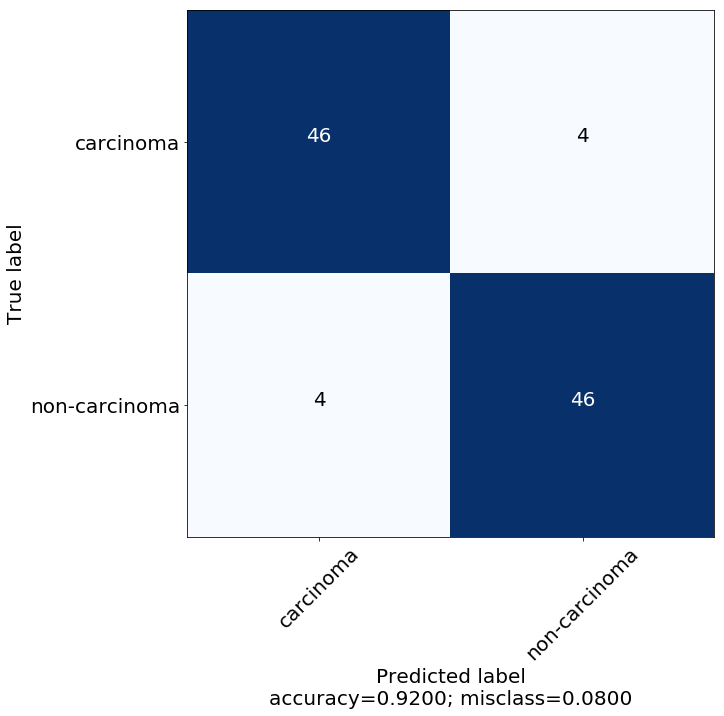

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[46  4]
 [ 4 46]]
               precision    recall  f1-score   support

non-carcinoma       0.92      0.92      0.92        50
    carcinoma       0.92      0.92      0.92        50

    micro avg       0.92      0.92      0.92       100
    macro avg       0.92      0.92      0.92       100
 weighted avg       0.92      0.92      0.92       100



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  92.0
Specificity :  92.0


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9199999999999999


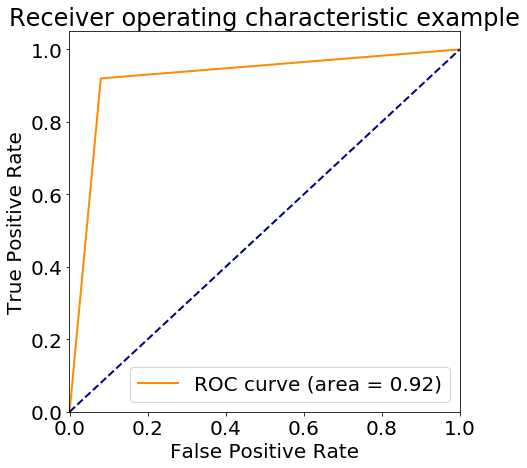

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 80us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

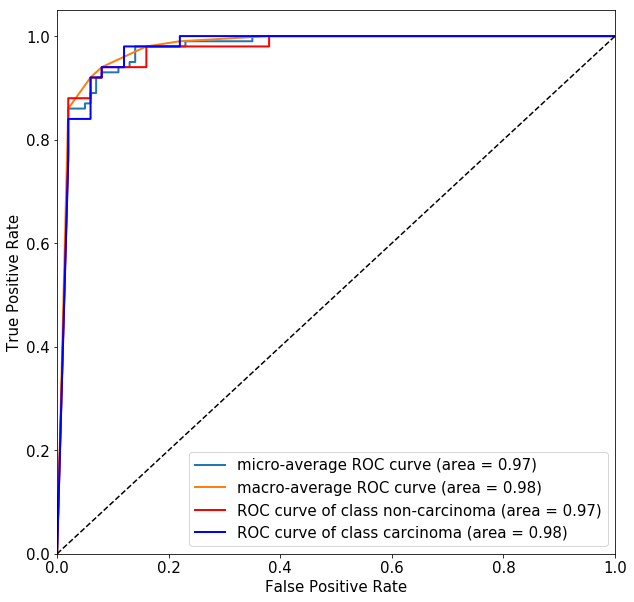

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
tp: 46
fp: 4
tn: 46
fn: 4


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.92


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.92


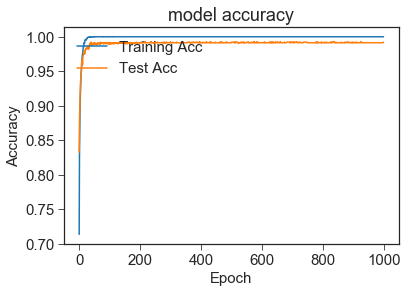

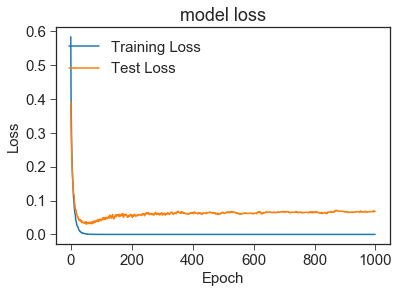

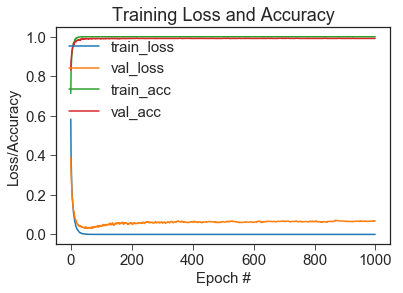

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")